### Fashion MNIST
This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images.

The classes are (Label - Description):<br />
0 - T-shirt/top<br />
1 - Trouser<br />
2 - Pullover<br />
3 - Dress<br />
4 - Coat<br />
5 - Sandal<br />
6 - Shirt<br />
7 - Sneaker<br />
8 - Bag<br />
9 - Ankle boot<br />

In [2]:
import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

Hiperparamtery, którę mogę modyfikować.
- liczba warstw;
- liczba neuronów;
- funkcje aktywacji;
- liczba epok;
- rozmiar paczki;
- wybór optymalizatora;
- różne techniki regularyzacji

### Wersja 1

Szkolenie sieciowe:
Dokładność wytrenowanej sieci neuronowej:  0.1001
Historia strat i dokładności:


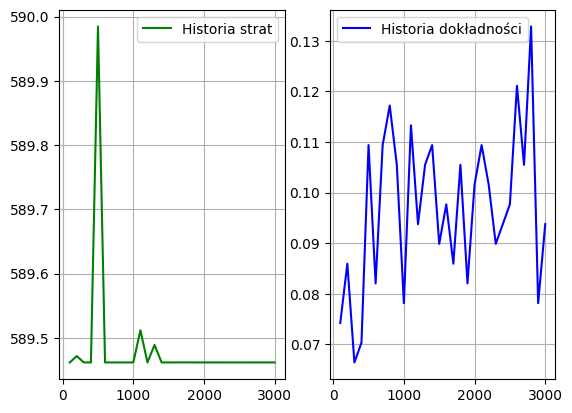

In [2]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

num_classes = 10 # całkowita liczba klas, w naszym przypadku są to liczby od 0 do 9
num_features = 784 # liczba atrybutów wektora wejściowego 28 * 28 = 784

learning_rate = 0.001 # szybkość uczenia się sieci neuronowej
training_steps = 3000 # maksymalna liczba epok
batch_size = 256 # wagi sieci na jej losowym podzbiorze elementów bat
display_step = 100 # co 100 iteracji pokażemy aktualną wartość funkcji straty i dokładności

n_hidden_1 = 128 # liczba neuronów warstwy 1
n_hidden_2 = 256 # liczba neuronów warstwy 2

# Konwersja pikseli całkowitych na typ float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Konwersja macierzy pikseli na wektor
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalizacja wartości pikseli
x_train, x_test = x_train / 255., x_test / 255.

# Wymieszanie danych treningowych
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

# Sieć neuronowa
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
        tf.random.normal([in_features, out_features]), name="w"
      )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        return tf.nn.relu(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    in_out = [num_features, n_hidden_1, n_hidden_2, num_classes]
    layers = []

    # Tworzenie warstw
    for i in range(len(in_out)-1):
      layers.append(DenseLayer(in_out[i], in_out[i+1], "layer"))
    self.layers = layers

  def __call__(self, x):
     i = 0
     n = len(self.layers)
     for layer in self.layers:
      i += 1
      x = layer(x)
      if i < n:
        x = tf.nn.sigmoid(x)
      else:
        x = tf.nn.softmax(x)
     return x


# Entropia krzyżowa jako funkcja błędu
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Dokładność  jako miernik jakości
def accuracy(y_pred, y_true):
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.cast(y_true, tf.int64)
    correct_prediction = tf.equal(y_pred, y_true)
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
# Przykładowa sieć neuronowa
neural_net = NN(name="fashionmnist")

# Funkcja treningu sieci neuronowej
def train(nn, input_x, output_y):
  # Do dopasowania wag sieci wykorzystano stochastycznego zejście gradientowe
  optimizer = tf.optimizers.SGD(learning_rate)
  # Aktywacja automatycznego różnicowania
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
    # zoptymalizowana lista parametrów
    variables = [layer.w for layer in nn.layers] + [layer.b for layer in nn.layers]
    # wartość gradientu
    gradient = g.gradient(loss, variables)
    # modyfikacja parametrów
    optimizer.apply_gradients(zip(gradient, variables))
    return loss


# Szkolenie sieci neuronowej
print("Szkolenie sieciowe:")
loss_history = []  # każdy krok display_step zapisuje bieżący błąd sieci neuronowej na tej liście
accuracy_history = [] # każdy krok display_step zapisuje aktualną dokładność sieci neuronowej na tej liście
displays_steps = []

# Trenowanie sieci neuronowej w pętli
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Aktualizacja wag sieci neuronowej
    loss  = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss_history.append(cross_entropy(pred, batch_y).numpy())
        accuracy_history.append(accuracy(pred, batch_y))
        displays_steps.append(step)

# Dokładność wytrenowanej sieci neuronowej
acc = accuracy(neural_net(x_test), y_test)
print("Dokładność wytrenowanej sieci neuronowej: ", acc)

# Wykres historii strat i dokładności
print("Historia strat i dokładności:")
plt.subplot(1, 2, 1)
plt.plot(displays_steps, loss_history, color='g')
plt.grid(True)
plt.legend(["Historia strat"])
plt.subplot(1, 2, 2)
plt.plot(displays_steps, accuracy_history, color='b')
plt.grid(True)
plt.legend(["Historia dokładności"])

### Wersja nr 2
Dodano regularyzację dropout, aby zapobiec nadmiernemu dopasowaniu.<br>
Zmieniono optymalizator na Adama.<br>
Zamieniono liczbę neuronów między 1 <> 2 warstwą.

Szkolenie sieciowe:
Dokładność wytrenowanej sieci neuronowej:  0.7211
Historia strat i dokładności:


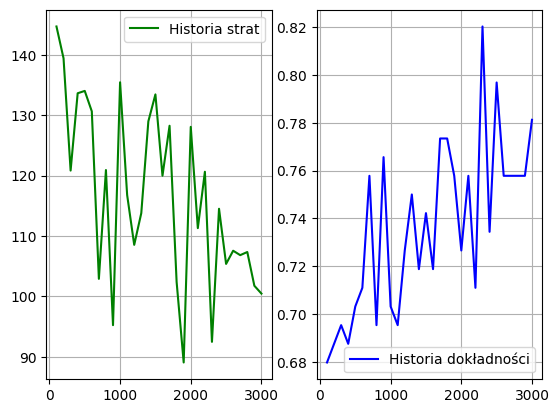

In [12]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

num_classes = 10 # całkowita liczba klas, w naszym przypadku są to liczby od 0 do 9
num_features = 784 # liczba atrybutów wektora wejściowego 28 * 28 = 784

learning_rate = 0.001 # szybkość uczenia się sieci neuronowej
training_steps = 3000 # maksymalna liczba epok
batch_size = 128 # wagi sieci na jej losowym podzbiorze elementów bat
display_step = 100 # co 100 iteracji pokażemy aktualną wartość funkcji straty i dokładności

n_hidden_1 = 512 # liczba neuronów warstwy 1
n_hidden_2 = 256 # liczba neuronów warstwy 2
dropout_rate = 0.5 # wskaźnik dropoutu

# Konwersja pikseli całkowitych na typ float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Konwersja macierzy pikseli na wektor
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalizacja wartości pikseli
x_train, x_test = x_train / 255., x_test / 255.

# Wymieszanie danych treningowych
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

# Sieć neuronowa
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, dropout_rate, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
        tf.random.normal([in_features, out_features]), name="w"
      )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")
        self.dropout_rate = dropout_rate

    def __call__(self, x, training):
        y = tf.matmul(x, self.w) + self.b
        y = tf.nn.relu(y)
        if training:
           y = tf.nn.dropout(y, rate=self.dropout_rate)
        return y

class NN(tf.Module):
  def __init__(self, name=None):
        super().__init__(name=name)
        in_out = [num_features, n_hidden_1, n_hidden_2, num_classes]
        self.layers = []
        
        for i in range(len(in_out) - 1):
            self.layers.append(DenseLayer(in_out[i], in_out[i+1], dropout_rate if i < len(in_out) - 2 else 0, "layer{}".format(i+1)))

  def __call__(self, x, training=False):
      for i, layer in enumerate(self.layers):
          x = layer(x, training)
          if i < len(self.layers) - 1:
              x = tf.nn.sigmoid(x)
      return tf.nn.softmax(x)


# Entropia krzyżowa jako funkcja błędu
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))


# Dokładność  jako miernik jakości
def accuracy(y_pred, y_true):
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.cast(y_true, tf.int64)
    correct_prediction = tf.equal(y_pred, y_true)
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()


# Przykładowa sieć neuronowa
neural_net = NN(name="fashionmnist")


# Funkcja treningu sieci neuronowej
def train(nn, input_x, output_y):
  # Do dopasowania wag sieci wykorzystano stochastycznego zejście gradientowe
  optimizer = tf.optimizers.Adam(learning_rate)
  # Aktywacja automatycznego różnicowania
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
    # zoptymalizowana lista parametrów
    variables = [layer.w for layer in nn.layers] + [layer.b for layer in nn.layers]
    # wartość gradientu
    gradient = g.gradient(loss, variables)
    # modyfikacja parametrów
    optimizer.apply_gradients(zip(gradient, variables))
    return loss


# Szkolenie sieci neuronowej
print("Szkolenie sieciowe:")
loss_history = []  # każdy krok display_step zapisuje bieżący błąd sieci neuronowej na tej liście
accuracy_history = [] # każdy krok display_step zapisuje aktualną dokładność sieci neuronowej na tej liście
displays_steps = []

# Trenowanie sieci neuronowej w pętli
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Aktualizacja wag sieci neuronowej
    loss  = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x, training=False)
        loss_history.append(cross_entropy(pred, batch_y).numpy())
        accuracy_history.append(accuracy(pred, batch_y))
        displays_steps.append(step)

# Dokładność wytrenowanej sieci neuronowej
acc = accuracy(neural_net(x_test, training=False), y_test)
print("Dokładność wytrenowanej sieci neuronowej: ", acc)

# Wykres historii strat i dokładności
print("Historia strat i dokładności:")
plt.subplot(1, 2, 1)
plt.plot(displays_steps, loss_history, color='g')
plt.grid(True)
plt.legend(["Historia strat"])
plt.subplot(1, 2, 2)
plt.plot(displays_steps, accuracy_history, color='b')
plt.grid(True)
plt.legend(["Historia dokładności"])

### Wersja 3
Dodano jeszcze jedną warstwę ukrytą.

Szkolenie sieciowe:
Dokładność wytrenowanej sieci neuronowej:  0.4431
Historia strat i dokładności:
Spostrzeżenia: Po dodaniu jeszcze jednej warstwy ukrytej i zmianie liczby epok na 5000, dokładnośc modelu wzrosła do:  0.4431


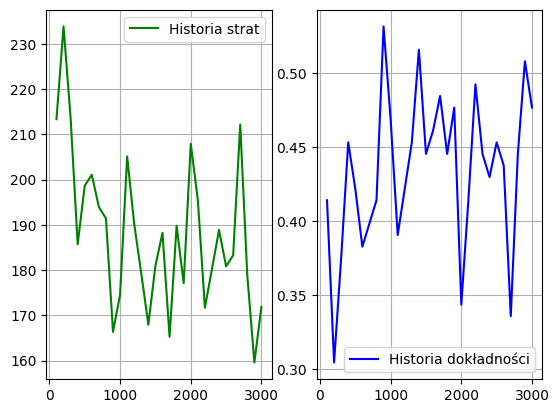

In [13]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

num_classes = 10 # całkowita liczba klas, w naszym przypadku są to liczby od 0 do 9
num_features = 784 # liczba atrybutów wektora wejściowego 28 * 28 = 784

learning_rate = 0.001 # szybkość uczenia się sieci neuronowej
training_steps = 3000 # maksymalna liczba epok
batch_size = 128 # wagi sieci na jej losowym podzbiorze elementów bat
display_step = 100 # co 100 iteracji pokażemy aktualną wartość funkcji straty i dokładności

n_hidden_1 = 512 # liczba neuronów warstwy 1
n_hidden_2 = 256 # liczba neuronów warstwy 2
n_hidden_3 = 128 # liczba neuronów warstwy 3
dropout_rate = 0.5 # wskaźnik dropoutu

# Konwersja pikseli całkowitych na typ float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Konwersja macierzy pikseli na wektor
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalizacja wartości pikseli
x_train, x_test = x_train / 255., x_test / 255.

# Wymieszanie danych treningowych
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

# Sieć neuronowa
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, dropout_rate, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
        tf.random.normal([in_features, out_features]), name="w"
      )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")
        self.dropout_rate = dropout_rate

    def __call__(self, x, training):
        y = tf.matmul(x, self.w) + self.b
        y = tf.nn.relu(y)
        if training:
           y = tf.nn.dropout(y, rate=self.dropout_rate)
        return y

class NN(tf.Module):
  def __init__(self, name=None):
        super().__init__(name=name)
        in_out = [num_features, n_hidden_1, n_hidden_2, num_classes]
        self.layers = []
        
        for i in range(len(in_out) - 1):
            self.layers.append(DenseLayer(in_out[i], in_out[i+1], dropout_rate if i < len(in_out) - 2 else 0, "layer{}".format(i+1)))

  def __call__(self, x, training=False):
      for i, layer in enumerate(self.layers):
          x = layer(x, training)
          if i < len(self.layers) - 1:
              x = tf.nn.sigmoid(x)
      return tf.nn.softmax(x)


# Entropia krzyżowa jako funkcja błędu
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))


# Dokładność  jako miernik jakości
def accuracy(y_pred, y_true):
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.cast(y_true, tf.int64)
    correct_prediction = tf.equal(y_pred, y_true)
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()


# Przykładowa sieć neuronowa
neural_net = NN(name="fashionmnist")


# Funkcja treningu sieci neuronowej
def train(nn, input_x, output_y):
  # Do dopasowania wag sieci wykorzystano stochastycznego zejście gradientowe
  optimizer = tf.optimizers.Adam(learning_rate)
  # Aktywacja automatycznego różnicowania
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
    # zoptymalizowana lista parametrów
    variables = [layer.w for layer in nn.layers] + [layer.b for layer in nn.layers]
    # wartość gradientu
    gradient = g.gradient(loss, variables)
    # modyfikacja parametrów
    optimizer.apply_gradients(zip(gradient, variables))
    return loss


# Szkolenie sieci neuronowej
print("Szkolenie sieciowe:")
loss_history = []  # każdy krok display_step zapisuje bieżący błąd sieci neuronowej na tej liście
accuracy_history = [] # każdy krok display_step zapisuje aktualną dokładność sieci neuronowej na tej liście
displays_steps = []

# Trenowanie sieci neuronowej w pętli
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Aktualizacja wag sieci neuronowej
    loss  = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x, training=False)
        loss_history.append(cross_entropy(pred, batch_y).numpy())
        accuracy_history.append(accuracy(pred, batch_y))
        displays_steps.append(step)

# Dokładność wytrenowanej sieci neuronowej
acc = accuracy(neural_net(x_test, training=False), y_test)
print("Dokładność wytrenowanej sieci neuronowej: ", acc)

# Wykres historii strat i dokładności
print("Historia strat i dokładności:")
plt.subplot(1, 2, 1)
plt.plot(displays_steps, loss_history, color='g')
plt.grid(True)
plt.legend(["Historia strat"])
plt.subplot(1, 2, 2)
plt.plot(displays_steps, accuracy_history, color='b')
plt.grid(True)
plt.legend(["Historia dokładności"])

### Wersja 4
Zmieniono funkcję w warstwie ukrytej z sigmoid na relu.

Szkolenie sieciowe:
Dokładność wytrenowanej sieci neuronowej:  0.3396
Historia strat i dokładności:


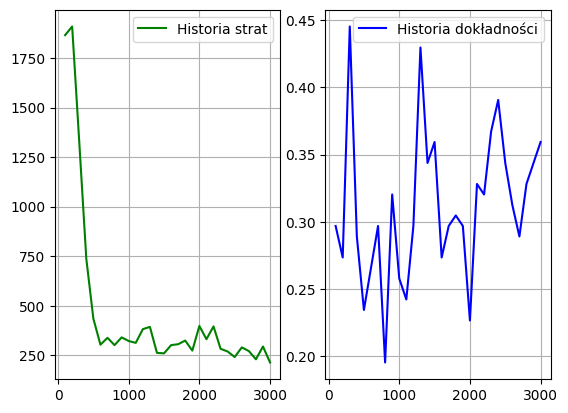

In [14]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

num_classes = 10 # całkowita liczba klas, w naszym przypadku są to liczby od 0 do 9
num_features = 784 # liczba atrybutów wektora wejściowego 28 * 28 = 784

learning_rate = 0.001 # szybkość uczenia się sieci neuronowej
training_steps = 3000 # maksymalna liczba epok
batch_size = 128 # wagi sieci na jej losowym podzbiorze elementów bat
display_step = 100 # co 100 iteracji pokażemy aktualną wartość funkcji straty i dokładności

n_hidden_1 = 512 # liczba neuronów warstwy 1
n_hidden_2 = 256 # liczba neuronów warstwy 2
n_hidden_3 = 128 # liczba neuronów warstwy 3
dropout_rate = 0.5 # wskaźnik dropoutu

# Konwersja pikseli całkowitych na typ float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Konwersja macierzy pikseli na wektor
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalizacja wartości pikseli
x_train, x_test = x_train / 255., x_test / 255.

# Wymieszanie danych treningowych
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

# Sieć neuronowa
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, dropout_rate, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
        tf.random.normal([in_features, out_features]), name="w"
      )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")
        self.dropout_rate = dropout_rate

    def __call__(self, x, training):
        y = tf.matmul(x, self.w) + self.b
        y = tf.nn.relu(y)
        if training:
           y = tf.nn.dropout(y, rate=self.dropout_rate)
        return y

class NN(tf.Module):
  def __init__(self, name=None):
        super().__init__(name=name)
        in_out = [num_features, n_hidden_1, n_hidden_2, num_classes]
        self.layers = []
        
        for i in range(len(in_out) - 1):
            self.layers.append(DenseLayer(in_out[i], in_out[i+1], dropout_rate if i < len(in_out) - 2 else 0, "layer{}".format(i+1)))

  def __call__(self, x, training=False):
      for i, layer in enumerate(self.layers):
          x = layer(x, training)
          if i < len(self.layers) - 1:
              x = tf.nn.relu(x)
      return tf.nn.softmax(x)


# Entropia krzyżowa jako funkcja błędu
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))


# Dokładność  jako miernik jakości
def accuracy(y_pred, y_true):
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.cast(y_true, tf.int64)
    correct_prediction = tf.equal(y_pred, y_true)
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()


# Przykładowa sieć neuronowa
neural_net = NN(name="fashionmnist")


# Funkcja treningu sieci neuronowej
def train(nn, input_x, output_y):
  # Do dopasowania wag sieci wykorzystano stochastycznego zejście gradientowe
  optimizer = tf.optimizers.Adam(learning_rate)
  # Aktywacja automatycznego różnicowania
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
    # zoptymalizowana lista parametrów
    variables = [layer.w for layer in nn.layers] + [layer.b for layer in nn.layers]
    # wartość gradientu
    gradient = g.gradient(loss, variables)
    # modyfikacja parametrów
    optimizer.apply_gradients(zip(gradient, variables))
    return loss


# Szkolenie sieci neuronowej
print("Szkolenie sieciowe:")
loss_history = []  # każdy krok display_step zapisuje bieżący błąd sieci neuronowej na tej liście
accuracy_history = [] # każdy krok display_step zapisuje aktualną dokładność sieci neuronowej na tej liście
displays_steps = []

# Trenowanie sieci neuronowej w pętli
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Aktualizacja wag sieci neuronowej
    loss  = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x, training=False)
        loss_history.append(cross_entropy(pred, batch_y).numpy())
        accuracy_history.append(accuracy(pred, batch_y))
        displays_steps.append(step)

# Dokładność wytrenowanej sieci neuronowej
acc = accuracy(neural_net(x_test, training=False), y_test)
print("Dokładność wytrenowanej sieci neuronowej: ", acc)

# Wykres historii strat i dokładności
print("Historia strat i dokładności:")
plt.subplot(1, 2, 1)
plt.plot(displays_steps, loss_history, color='g')
plt.grid(True)
plt.legend(["Historia strat"])
plt.subplot(1, 2, 2)
plt.plot(displays_steps, accuracy_history, color='b')
plt.grid(True)
plt.legend(["Historia dokładności"])

### Wersja 5
Do skopiowanej wersji 2 zmieniono funkcję w warstwie ukrytej z sigmoid na relu.

Szkolenie sieciowe:
Dokładność wytrenowanej sieci neuronowej:  0.3592
Historia strat i dokładności:


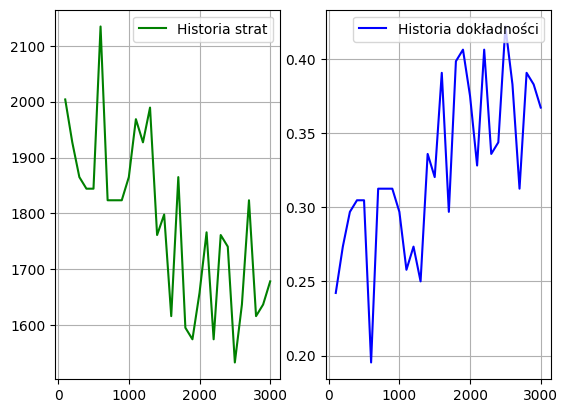

In [15]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

num_classes = 10 # całkowita liczba klas, w naszym przypadku są to liczby od 0 do 9
num_features = 784 # liczba atrybutów wektora wejściowego 28 * 28 = 784

learning_rate = 0.001 # szybkość uczenia się sieci neuronowej
training_steps = 3000 # maksymalna liczba epok
batch_size = 128 # wagi sieci na jej losowym podzbiorze elementów bat
display_step = 100 # co 100 iteracji pokażemy aktualną wartość funkcji straty i dokładności

n_hidden_1 = 512 # liczba neuronów warstwy 1
n_hidden_2 = 256 # liczba neuronów warstwy 2
dropout_rate = 0.5 # wskaźnik dropoutu

# Konwersja pikseli całkowitych na typ float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Konwersja macierzy pikseli na wektor
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalizacja wartości pikseli
x_train, x_test = x_train / 255., x_test / 255.

# Wymieszanie danych treningowych
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

# Sieć neuronowa
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, dropout_rate, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
        tf.random.normal([in_features, out_features]), name="w"
      )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")
        self.dropout_rate = dropout_rate

    def __call__(self, x, training):
        y = tf.matmul(x, self.w) + self.b
        y = tf.nn.relu(y)
        if training:
           y = tf.nn.dropout(y, rate=self.dropout_rate)
        return y

class NN(tf.Module):
  def __init__(self, name=None):
        super().__init__(name=name)
        in_out = [num_features, n_hidden_1, n_hidden_2, num_classes]
        self.layers = []
        
        for i in range(len(in_out) - 1):
            self.layers.append(DenseLayer(in_out[i], in_out[i+1], dropout_rate if i < len(in_out) - 2 else 0, "layer{}".format(i+1)))

  def __call__(self, x, training=False):
      for i, layer in enumerate(self.layers):
          x = layer(x, training)
          if i < len(self.layers) - 1:
              x = tf.nn.relu(x)
      return tf.nn.softmax(x)


# Entropia krzyżowa jako funkcja błędu
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))


# Dokładność  jako miernik jakości
def accuracy(y_pred, y_true):
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.cast(y_true, tf.int64)
    correct_prediction = tf.equal(y_pred, y_true)
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()


# Przykładowa sieć neuronowa
neural_net = NN(name="fashionmnist")


# Funkcja treningu sieci neuronowej
def train(nn, input_x, output_y):
  # Do dopasowania wag sieci wykorzystano stochastycznego zejście gradientowe
  optimizer = tf.optimizers.Adam(learning_rate)
  # Aktywacja automatycznego różnicowania
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
    # zoptymalizowana lista parametrów
    variables = [layer.w for layer in nn.layers] + [layer.b for layer in nn.layers]
    # wartość gradientu
    gradient = g.gradient(loss, variables)
    # modyfikacja parametrów
    optimizer.apply_gradients(zip(gradient, variables))
    return loss


# Szkolenie sieci neuronowej
print("Szkolenie sieciowe:")
loss_history = []  # każdy krok display_step zapisuje bieżący błąd sieci neuronowej na tej liście
accuracy_history = [] # każdy krok display_step zapisuje aktualną dokładność sieci neuronowej na tej liście
displays_steps = []

# Trenowanie sieci neuronowej w pętli
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Aktualizacja wag sieci neuronowej
    loss  = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x, training=False)
        loss_history.append(cross_entropy(pred, batch_y).numpy())
        accuracy_history.append(accuracy(pred, batch_y))
        displays_steps.append(step)

# Dokładność wytrenowanej sieci neuronowej
acc = accuracy(neural_net(x_test, training=False), y_test)
print("Dokładność wytrenowanej sieci neuronowej: ", acc)

# Wykres historii strat i dokładności
print("Historia strat i dokładności:")
plt.subplot(1, 2, 1)
plt.plot(displays_steps, loss_history, color='g')
plt.grid(True)
plt.legend(["Historia strat"])
plt.subplot(1, 2, 2)
plt.plot(displays_steps, accuracy_history, color='b')
plt.grid(True)
plt.legend(["Historia dokładności"])

### Wersja 6
Dla wersji 2 dodano regularyzator Ridge.

Szkolenie sieciowe:
Dokładność wytrenowanej sieci neuronowej:  0.5321
Historia strat i dokładności:


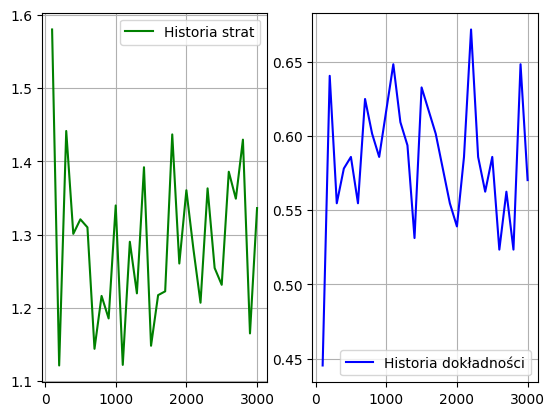

In [16]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

num_classes = 10 # całkowita liczba klas, w naszym przypadku są to liczby od 0 do 9
num_features = 784 # liczba atrybutów wektora wejściowego 28 * 28 = 784

learning_rate = 0.001 # szybkość uczenia się sieci neuronowej
training_steps = 3000 # maksymalna liczba epok
batch_size = 128 # wagi sieci na jej losowym podzbiorze elementów bat
display_step = 100 # co 100 iteracji pokażemy aktualną wartość funkcji straty i dokładności

n_hidden_1 = 512 # liczba neuronów warstwy 1
n_hidden_2 = 256 # liczba neuronów warstwy 2
dropout_rate = 0.5 # wskaźnik dropoutu
l2_lambda = 0.001 # współczynnik regularyzacji L2

# Konwersja pikseli całkowitych na typ float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Konwersja macierzy pikseli na wektor
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalizacja wartości pikseli
x_train, x_test = x_train / 255., x_test / 255.

# Wymieszanie danych treningowych
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

# Sieć neuronowa
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, dropout_rate, l2_lambda, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda

    def __call__(self, x, training):
        y = tf.matmul(x, self.w) + self.b
        y = tf.nn.relu(y)
        if training:
            y = tf.nn.dropout(y, rate=self.dropout_rate)
        return y
    
    def l2_loss(self):
        return self.l2_lambda * tf.nn.l2_loss(self.w)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        in_out = [num_features, n_hidden_1, n_hidden_2, num_classes]
        self.layers = []
        
        for i in range(len(in_out) - 1):
            self.layers.append(DenseLayer(in_out[i], in_out[i+1], dropout_rate if i < len(in_out) - 2 else 0, l2_lambda, "layer{}".format(i+1)))

    def __call__(self, x, training=False):
        for i, layer in enumerate(self.layers):
            x = layer(x, training)
            if i < len(self.layers) - 1:
                x = tf.nn.sigmoid(x)
        return tf.nn.softmax(x)

    def l2_loss(self):
        return tf.reduce_sum([layer.l2_loss() for layer in self.layers])

# Entropia krzyżowa jako funkcja błędu
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

# Dokładność  jako miernik jakości
def accuracy(y_pred, y_true):
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.cast(y_true, tf.int64)
    correct_prediction = tf.equal(y_pred, y_true)
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()

# Przykładowa sieć neuronowa
neural_net = NN(name="fashionmnist")

# Funkcja treningu sieci neuronowej
def train(nn, input_x, output_y):
    # Do dopasowania wag sieci wykorzystano stochastycznego zejście gradientowe
    optimizer = tf.optimizers.Adam(learning_rate)
    # Aktywacja automatycznego różnicowania
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y) + neural_net.l2_loss()
        # zoptymalizowana lista parametrów
        variables = [layer.w for layer in nn.layers] + [layer.b for layer in nn.layers]
        # wartość gradientu
        gradient = g.gradient(loss, variables)
        # modyfikacja parametrów
        optimizer.apply_gradients(zip(gradient, variables))
        return loss

# Szkolenie sieci neuronowej
print("Szkolenie sieciowe:")
loss_history = []  # każdy krok display_step zapisuje bieżący błąd sieci neuronowej na tej liście
accuracy_history = [] # każdy krok display_step zapisuje aktualną dokładność sieci neuronowej na tej liście
displays_steps = []

# Trenowanie sieci neuronowej w pętli
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Aktualizacja wag sieci neuronowej
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x, training=False)
        loss_history.append(cross_entropy(pred, batch_y).numpy())
        accuracy_history.append(accuracy(pred, batch_y))
        displays_steps.append(step)

# Dokładność wytrenowanej sieci neuronowej
acc = accuracy(neural_net(x_test, training=False), y_test)
print("Dokładność wytrenowanej sieci neuronowej: ", acc)

# Wykres historii strat i dokładności
print("Historia strat i dokładności:")
plt.subplot(1, 2, 1)
plt.plot(displays_steps, loss_history, color='g')
plt.grid(True)
plt.legend(["Historia strat"])
plt.subplot(1, 2, 2)
plt.plot(displays_steps, accuracy_history, color='b')
plt.grid(True)
plt.legend(["Historia dokładności"])
plt.show()


### Wersja 7
Dodano kolejną warstwę ukrytą do wersji 6.

Szkolenie sieciowe:
Dokładność wytrenowanej sieci neuronowej:  0.5331
Historia strat i dokładności:


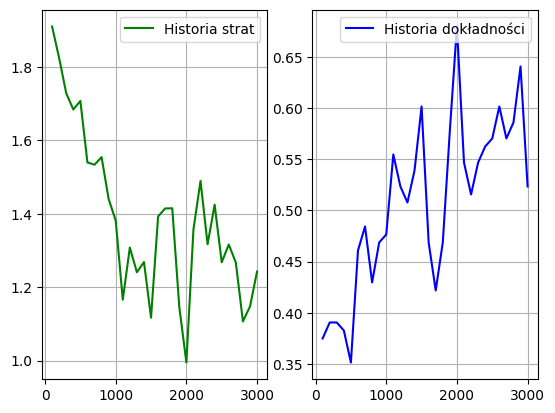

In [18]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

num_classes = 10 # całkowita liczba klas, w naszym przypadku są to liczby od 0 do 9
num_features = 784 # liczba atrybutów wektora wejściowego 28 * 28 = 784

learning_rate = 0.001 # szybkość uczenia się sieci neuronowej
training_steps = 3000 # maksymalna liczba epok
batch_size = 128 # wagi sieci na jej losowym podzbiorze elementów bat
display_step = 100 # co 100 iteracji pokażemy aktualną wartość funkcji straty i dokładności

n_hidden_1 = 512 # liczba neuronów warstwy 1
n_hidden_2 = 256 # liczba neuronów warstwy 2
n_hidden_3 = 128 # liczba neuronów warstwy 3
dropout_rate = 0.5 # wskaźnik dropoutu
l2_lambda = 0.001 # współczynnik regularyzacji L2

# Konwersja pikseli całkowitych na typ float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Konwersja macierzy pikseli na wektor
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalizacja wartości pikseli
x_train, x_test = x_train / 255., x_test / 255.

# Wymieszanie danych treningowych
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

# Sieć neuronowa
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, dropout_rate, l2_lambda, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda

    def __call__(self, x, training):
        y = tf.matmul(x, self.w) + self.b
        y = tf.nn.relu(y)
        if training:
            y = tf.nn.dropout(y, rate=self.dropout_rate)
        return y
    
    def l2_loss(self):
        return self.l2_lambda * tf.nn.l2_loss(self.w)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        in_out = [num_features, n_hidden_1, n_hidden_2, n_hidden_3, num_classes]
        self.layers = []
        
        for i in range(len(in_out) - 1):
            self.layers.append(DenseLayer(in_out[i], in_out[i+1], dropout_rate if i < len(in_out) - 2 else 0, l2_lambda, "layer{}".format(i+1)))

    def __call__(self, x, training=False):
        for i, layer in enumerate(self.layers):
            x = layer(x, training)
            if i < len(self.layers) - 1:
                x = tf.nn.sigmoid(x)
        return tf.nn.softmax(x)

    def l2_loss(self):
        return tf.reduce_sum([layer.l2_loss() for layer in self.layers])

# Entropia krzyżowa jako funkcja błędu
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

# Dokładność  jako miernik jakości
def accuracy(y_pred, y_true):
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.cast(y_true, tf.int64)
    correct_prediction = tf.equal(y_pred, y_true)
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()

# Przykładowa sieć neuronowa
neural_net = NN(name="fashionmnist")

# Funkcja treningu sieci neuronowej
def train(nn, input_x, output_y):
    # Do dopasowania wag sieci wykorzystano stochastycznego zejście gradientowe
    optimizer = tf.optimizers.Adam(learning_rate)
    # Aktywacja automatycznego różnicowania
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y) + neural_net.l2_loss()
        # zoptymalizowana lista parametrów
        variables = [layer.w for layer in nn.layers] + [layer.b for layer in nn.layers]
        # wartość gradientu
        gradient = g.gradient(loss, variables)
        # modyfikacja parametrów
        optimizer.apply_gradients(zip(gradient, variables))
        return loss

# Szkolenie sieci neuronowej
print("Szkolenie sieciowe:")
loss_history = []  # każdy krok display_step zapisuje bieżący błąd sieci neuronowej na tej liście
accuracy_history = [] # każdy krok display_step zapisuje aktualną dokładność sieci neuronowej na tej liście
displays_steps = []

# Trenowanie sieci neuronowej w pętli
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Aktualizacja wag sieci neuronowej
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x, training=False)
        loss_history.append(cross_entropy(pred, batch_y).numpy())
        accuracy_history.append(accuracy(pred, batch_y))
        displays_steps.append(step)

# Dokładność wytrenowanej sieci neuronowej
acc = accuracy(neural_net(x_test, training=False), y_test)
print("Dokładność wytrenowanej sieci neuronowej: ", acc)

# Wykres historii strat i dokładności
print("Historia strat i dokładności:")
plt.subplot(1, 2, 1)
plt.plot(displays_steps, loss_history, color='g')
plt.grid(True)
plt.legend(["Historia strat"])
plt.subplot(1, 2, 2)
plt.plot(displays_steps, accuracy_history, color='b')
plt.grid(True)
plt.legend(["Historia dokładności"])
plt.show()


### Wersja 8
Zmieniono liczbę neuronów.

Szkolenie sieciowe:
Dokładność wytrenowanej sieci neuronowej:  0.4041
Historia strat i dokładności:


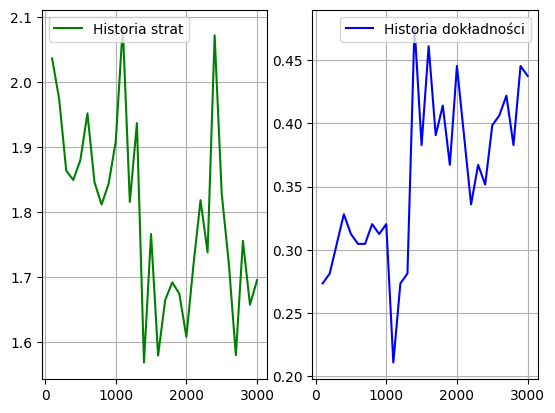

In [20]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

num_classes = 10 # całkowita liczba klas, w naszym przypadku są to liczby od 0 do 9
num_features = 784 # liczba atrybutów wektora wejściowego 28 * 28 = 784

learning_rate = 0.001 # szybkość uczenia się sieci neuronowej
training_steps = 3000 # maksymalna liczba epok
batch_size = 128 # wagi sieci na jej losowym podzbiorze elementów bat
display_step = 100 # co 100 iteracji pokażemy aktualną wartość funkcji straty i dokładności

n_hidden_1 = 768 # liczba neuronów warstwy 1
n_hidden_2 = 384 # liczba neuronów warstwy 2
n_hidden_3 = 192 # liczba neuronów warstwy 3
dropout_rate = 0.5 # wskaźnik dropoutu
l2_lambda = 0.001 # współczynnik regularyzacji L2

# Konwersja pikseli całkowitych na typ float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Konwersja macierzy pikseli na wektor
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalizacja wartości pikseli
x_train, x_test = x_train / 255., x_test / 255.

# Wymieszanie danych treningowych
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

# Sieć neuronowa
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, dropout_rate, l2_lambda, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda

    def __call__(self, x, training):
        y = tf.matmul(x, self.w) + self.b
        y = tf.nn.relu(y)
        if training:
            y = tf.nn.dropout(y, rate=self.dropout_rate)
        return y
    
    def l2_loss(self):
        return self.l2_lambda * tf.nn.l2_loss(self.w)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        in_out = [num_features, n_hidden_1, n_hidden_2, n_hidden_3, num_classes]
        self.layers = []
        
        for i in range(len(in_out) - 1):
            self.layers.append(DenseLayer(in_out[i], in_out[i+1], dropout_rate if i < len(in_out) - 2 else 0, l2_lambda, "layer{}".format(i+1)))

    def __call__(self, x, training=False):
        for i, layer in enumerate(self.layers):
            x = layer(x, training)
            if i < len(self.layers) - 1:
                x = tf.nn.sigmoid(x)
        return tf.nn.softmax(x)

    def l2_loss(self):
        return tf.reduce_sum([layer.l2_loss() for layer in self.layers])

# Entropia krzyżowa jako funkcja błędu
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

# Dokładność  jako miernik jakości
def accuracy(y_pred, y_true):
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.cast(y_true, tf.int64)
    correct_prediction = tf.equal(y_pred, y_true)
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()

# Przykładowa sieć neuronowa
neural_net = NN(name="fashionmnist")

# Funkcja treningu sieci neuronowej
def train(nn, input_x, output_y):
    # Do dopasowania wag sieci wykorzystano stochastycznego zejście gradientowe
    optimizer = tf.optimizers.Adam(learning_rate)
    # Aktywacja automatycznego różnicowania
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y) + neural_net.l2_loss()
        # zoptymalizowana lista parametrów
        variables = [layer.w for layer in nn.layers] + [layer.b for layer in nn.layers]
        # wartość gradientu
        gradient = g.gradient(loss, variables)
        # modyfikacja parametrów
        optimizer.apply_gradients(zip(gradient, variables))
        return loss

# Szkolenie sieci neuronowej
print("Szkolenie sieciowe:")
loss_history = []  # każdy krok display_step zapisuje bieżący błąd sieci neuronowej na tej liście
accuracy_history = [] # każdy krok display_step zapisuje aktualną dokładność sieci neuronowej na tej liście
displays_steps = []

# Trenowanie sieci neuronowej w pętli
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Aktualizacja wag sieci neuronowej
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x, training=False)
        loss_history.append(cross_entropy(pred, batch_y).numpy())
        accuracy_history.append(accuracy(pred, batch_y))
        displays_steps.append(step)

# Dokładność wytrenowanej sieci neuronowej
acc = accuracy(neural_net(x_test, training=False), y_test)
print("Dokładność wytrenowanej sieci neuronowej: ", acc)

# Wykres historii strat i dokładności
print("Historia strat i dokładności:")
plt.subplot(1, 2, 1)
plt.plot(displays_steps, loss_history, color='g')
plt.grid(True)
plt.legend(["Historia strat"])
plt.subplot(1, 2, 2)
plt.plot(displays_steps, accuracy_history, color='b')
plt.grid(True)
plt.legend(["Historia dokładności"])
plt.show()


### Wersja 8
Dodano metodę wczesnego zatrzymywania do wcześniejszej wersji modelu.

Szkolenie sieciowe:
Step: 100, Train Loss: 2.3025851249694824, Train Accuracy: 0.1484375, Val Loss: 2.3025851249694824, Val Accuracy: 0.10502944522081538
Step: 200, Train Loss: 2.3025851249694824, Train Accuracy: 0.0703125, Val Loss: 2.3025851249694824, Val Accuracy: 0.10502944522081538
Step: 300, Train Loss: 2.3025851249694824, Train Accuracy: 0.0859375, Val Loss: 2.3025851249694824, Val Accuracy: 0.10502944522081538
Step: 400, Train Loss: 2.3025851249694824, Train Accuracy: 0.0859375, Val Loss: 2.3025851249694824, Val Accuracy: 0.10502944522081538
Dokładność wytrenowanej sieci neuronowej:  0.1
Historia strat i dokładności:


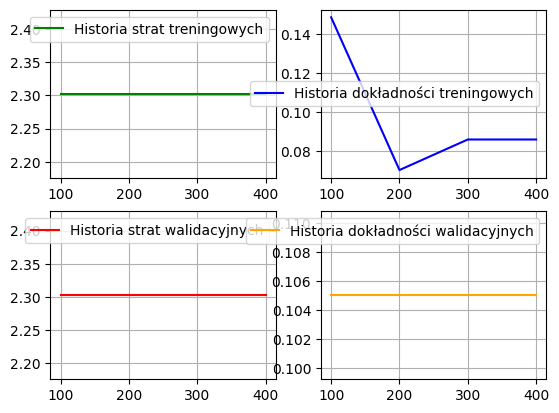

In [21]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

# Załadowanie danych
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Podział danych na treningowe i walidacyjne
validation_split = 0.1
split_index = int((1 - validation_split) * len(x_train))
x_train, x_val = x_train[:split_index], x_train[split_index:]
y_train, y_val = y_train[:split_index], y_train[split_index:]

num_classes = 10  # całkowita liczba klas
num_features = 784  # liczba atrybutów wektora wejściowego 28 * 28 = 784

learning_rate = 0.001  # szybkość uczenia się sieci neuronowej
training_steps = 5000  # maksymalna liczba epok
batch_size = 128  # przeliczymy wagi sieci nie na całej próbce, ale na jej losowym podzbiorze elementów bat
display_step = 100  # co 100 iteracji pokażemy aktualną wartość funkcji straty i dokładności
patience = 10  # liczba epok do wczesnego zatrzymania bez poprawy

n_hidden_1 = 512  # liczba neuronów warstwy 1
n_hidden_2 = 256  # liczba neuronów warstwy 2
n_hidden_3 = 128  # liczba neuronów warstwy 3
dropout_rate = 0.5  # wskaźnik dropoutu

# Konwersja pikseli całkowitych na typ float32
x_train, x_val, x_test = map(lambda x: np.array(x, np.float32), [x_train, x_val, x_test])

# Konwersja macierzy pikseli na wektor
x_train, x_val, x_test = map(lambda x: x.reshape([-1, num_features]), [x_train, x_val, x_test])

# Normalizacja wartości pikseli
x_train, x_val, x_test = map(lambda x: x / 255., [x_train, x_val, x_test])

# Wymieszanie danych treningowych
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(batch_size).prefetch(1)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size).prefetch(1)

# Sieć neuronowa
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, dropout_rate, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")
        self.dropout_rate = dropout_rate

    def __call__(self, x, training):
        y = tf.matmul(x, self.w) + self.b
        y = tf.nn.relu(y)
        if training and self.dropout_rate > 0:
            y = tf.nn.dropout(y, rate=self.dropout_rate)
        return y

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        in_out = [num_features, n_hidden_1, n_hidden_2, n_hidden_3, num_classes]
        self.layers = [DenseLayer(in_out[i], in_out[i+1], dropout_rate if i < len(in_out) - 2 else 0, "layer{}".format(i+1)) for i in range(len(in_out) - 1)]

    def __call__(self, x, training=False):
        for i, layer in enumerate(self.layers):
            x = layer(x, training)
            if i < len(self.layers) - 1:
                x = tf.nn.sigmoid(x)
        return tf.nn.softmax(x)

# Entropia krzyżowa jako funkcja błędu
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

# Dokładność jako miernik jakości
def accuracy(y_pred, y_true):
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.cast(y_true, tf.int64)
    correct_prediction = tf.equal(y_pred, y_true)
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()

# Przykładowa sieć neuronowa
neural_net = NN(name="fashionmnist")

# Funkcja treningu sieci neuronowej
def train(nn, input_x, output_y):
    optimizer = tf.optimizers.Adam(learning_rate)
    with tf.GradientTape() as g:
        pred = nn(input_x, training=True)
        loss = cross_entropy(pred, output_y)
    variables = [var for layer in nn.layers for var in [layer.w, layer.b]]
    gradient = g.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradient, variables))
    return loss

# Funkcja do walidacji
def validate(nn, val_data):
    val_loss = 0
    val_acc = 0
    num_batches = 0
    for batch_x, batch_y in val_data:
        pred = nn(batch_x, training=False)
        val_loss += cross_entropy(pred, batch_y).numpy()
        val_acc += accuracy(pred, batch_y)
        num_batches += 1
    return val_loss / num_batches, val_acc / num_batches

# Szkolenie sieci neuronowej
print("Szkolenie sieciowe:")
loss_history = []
accuracy_history = []
val_loss_history = []
val_accuracy_history = []
displays_steps = []

best_val_loss = float('inf')
patience_counter = 0

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    loss = train(neural_net, batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x, training=False)
        train_loss = cross_entropy(pred, batch_y).numpy()
        train_acc = accuracy(pred, batch_y)
        
        val_loss, val_acc = validate(neural_net, val_data)
        
        loss_history.append(train_loss)
        accuracy_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_acc)
        displays_steps.append(step)
        
        print(f"Step: {step}, Train Loss: {train_loss}, Train Accuracy: {train_acc}, Val Loss: {val_loss}, Val Accuracy: {val_acc}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Wczesne zatrzymanie!")
            break

# Dokładność wytrenowanej sieci neuronowej
acc = accuracy(neural_net(x_test, training=False), y_test)
print("Dokładność wytrenowanej sieci neuronowej: ", acc)

# Wykres historii strat i dokładności
print("Historia strat i dokładności:")
plt.subplot(2, 2, 1)
plt.plot(displays_steps, loss_history, color='g')
plt.grid(True)
plt.legend(["Historia strat treningowych"])
plt.subplot(2, 2, 2)
plt.plot(displays_steps, accuracy_history, color='b')
plt.grid(True)
plt.legend(["Historia dokładności treningowych"])
plt.subplot(2, 2, 3)
plt.plot(displays_steps, val_loss_history, color='r')
plt.grid(True)
plt.legend(["Historia strat walidacyjnych"])
plt.subplot(2, 2, 4)
plt.plot(displays_steps, val_accuracy_history, color='orange')
plt.grid(True)
plt.legend(["Historia dokładności walidacyjnych"])
plt.show()

### Wersja 9
Sposób z wersji z drugiego wykładu w ramach modułu.

c:\Users\kdrajok\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 768)            │       602,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 384)            │       295,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 192)            │        73,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,930 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 974,026 (3.72 MB)

 Trainable params: 974,026 (3.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
469/469 - 5s - 10ms/step - accuracy: 0.8254 - loss: 0.4820 - val_accuracy: 0.8533 - val_loss: 0.4025
Epoch 2/6
469/469 - 4s - 8ms/step - accuracy: 0.8688 - loss: 0.3588 - val_accuracy: 0.8697 - val_loss: 0.3716
Epoch 3/6
469/469 - 4s - 8ms/step - accuracy: 0.8802 - loss: 0.3215 - val_accuracy: 0.8709 - val_loss: 0.3513
Epoch 4/6
469/469 - 4s - 8ms/step - accuracy: 0.8906 - loss: 0.2927 - val_accuracy: 0.8667 - val_loss: 0.3646
Epoch 5/6
469/469 - 4s - 8ms/step - accuracy: 0.8963 - loss: 0.2754 - val_accuracy: 0.8800 - val_loss: 0.3355
Epoch 6/6
469/469 - 4s - 8ms/step - accuracy: 0.9006 - loss: 0.2634 - val_accuracy: 0.8788 - val_loss: 0.3392
313/313 - 0s - 1ms/step - accuracy: 0.8788 - loss: 0.3392

Dokładnośc testowa: 0.8787999749183655
Historia straty i dokładności:


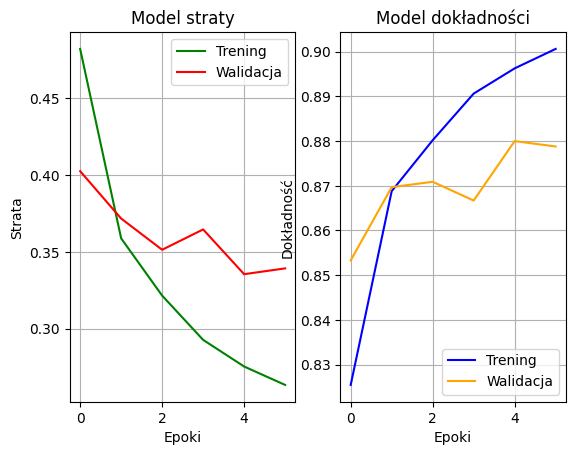

In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam

# Ładowanie danych
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Parametry
num_classes = 10 # Number of classes
num_features = 784 # Number of input features (28*28)

learning_rate = 0.001
training_steps = 3000
batch_size = 128


# Konwersja
x_train, x_test = x_train / 255.0, x_test / 255.0

# Budowa sieci neuronowej
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(768, activation='relu'),
    Dense(384, activation='relu'),
    Dense(192, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Kompilacja modelu
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Podsumowwanie
model.summary()

# Trenowanie modelu
history = model.fit(
    x_train, y_train,
    epochs=training_steps // (len(x_train) // batch_size),
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=2
)

# Ocena modelu
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nDokładnośc testowa:', test_acc)

# Wykresy
print("Historia straty i dokładności:")
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], color='g')
plt.plot(history.history['val_loss'], color='r')
plt.title("Model straty")
plt.xlabel("Epoki")
plt.ylabel("Strata")
plt.legend(["Trening", "Walidacja"], loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['val_accuracy'], color='orange')
plt.title("Model dokładności")
plt.xlabel("Epoki")
plt.ylabel("Dokładność")
plt.legend(["Trening", "Walidacja"], loc='lower right')
plt.grid(True)

plt.show()


### Wersja 10
Zmiana liczby neuronów.<br>
Dodanie warstw Dropout.<br>
Dodanie EarlyStopping

Epoch 1/6
469/469 - 6s - 13ms/step - accuracy: 0.7418 - loss: 0.7840 - val_accuracy: 0.8151 - val_loss: 0.5245
Epoch 2/6
469/469 - 5s - 11ms/step - accuracy: 0.7909 - loss: 0.5969 - val_accuracy: 0.8157 - val_loss: 0.5100
Epoch 3/6
469/469 - 5s - 11ms/step - accuracy: 0.8025 - loss: 0.5657 - val_accuracy: 0.8135 - val_loss: 0.5283
Epoch 4/6
469/469 - 5s - 11ms/step - accuracy: 0.7997 - loss: 0.5749 - val_accuracy: 0.8398 - val_loss: 0.4740
Epoch 5/6
469/469 - 5s - 11ms/step - accuracy: 0.8038 - loss: 0.5702 - val_accuracy: 0.8302 - val_loss: 0.5128
Epoch 6/6
469/469 - 5s - 12ms/step - accuracy: 0.8038 - loss: 0.5627 - val_accuracy: 0.8156 - val_loss: 0.5182
313/313 - 1s - 2ms/step - accuracy: 0.8156 - loss: 0.5182

Dokładnośc testowa: 0.8155999779701233
Dostępne klucze w historii: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Historia straty i dokładności:


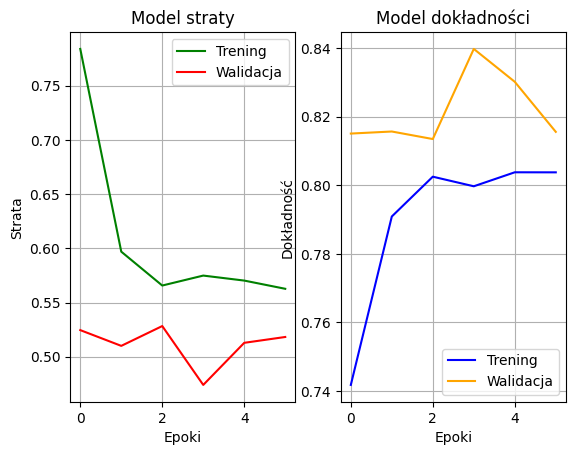

In [62]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input

# Przygotowanie danych
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Konwersja i normalizacja danych
x_train = x_train.reshape((-1, 28, 28, 1)) / 255.0
x_test = x_test.reshape((-1, 28, 28, 1)) / 255.0

# Hiperparametry
num_classes = 10 # Number of classes
num_features = 784 # Number of input features (28*28)
num_layers=3
learning_rate = 0.01
training_steps = 3000
batch_size = 128
activation_hidden='relu'
activation_exit='softmax'
dropout_rate = 0.2

def create_model(learning_rate=0.01, num_layers=2, activation_hidden='relu', activation_exit='softmax', dropout_rate=0.5):
    model = Sequential()
    model.add(Input(shape=(28, 28, 1)))
    model.add(Flatten())
    for _ in range(num_layers):
        model.add(Dense(512, activation=activation_hidden))
        model.add(Dropout(dropout_rate))
    model.add(Dense(256, activation=activation_exit))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=["accuracy"])
    return model

# Tworzenie modelu z przykładowymi hiperparametrami regularyzacji
model = create_model(learning_rate=learning_rate, num_layers=num_layers, activation_hidden=activation_hidden, activation_exit=activation_exit, dropout_rate=dropout_rate)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Trenowanie modelu
history = model.fit(
    x_train, y_train,
    epochs=training_steps // (len(x_train) // batch_size),
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=2,
    callbacks=[early_stopping]
)

# Ocena modelu
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nDokładnośc testowa:', test_acc)

# Sprawdzenie dostępnych kluczy w historii
print("Dostępne klucze w historii:", history.history.keys())

# Wykresy
print("Historia straty i dokładności:")
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='g')
plt.plot(history.history['val_loss'], label='Validation Loss', color='r')
plt.title("Model straty")
plt.xlabel("Epoki")
plt.ylabel("Strata")
plt.legend(["Trening", "Walidacja"], loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['val_accuracy'], color='orange')
plt.title("Model dokładności")
plt.xlabel("Epoki")
plt.ylabel("Dokładność")
plt.legend(["Trening", "Walidacja"], loc='lower right')
plt.grid(True)

plt.show()

### Wersja 11
Dodanie regularyzacji L1.<br>

Epoch 1/6
469/469 - 7s - 14ms/step - accuracy: 0.0996 - loss: 17.9817 - val_accuracy: 0.1000 - val_loss: 13.8434
Epoch 2/6
469/469 - 6s - 13ms/step - accuracy: 0.1005 - loss: 13.6297 - val_accuracy: 0.1000 - val_loss: 13.5816
Epoch 3/6
469/469 - 7s - 15ms/step - accuracy: 0.0975 - loss: 13.5335 - val_accuracy: 0.1000 - val_loss: 13.3450
Epoch 4/6
469/469 - 7s - 15ms/step - accuracy: 0.1006 - loss: 13.4911 - val_accuracy: 0.1000 - val_loss: 13.4720
Epoch 5/6
469/469 - 7s - 15ms/step - accuracy: 0.0983 - loss: 13.4707 - val_accuracy: 0.1000 - val_loss: 13.3555
Epoch 6/6
469/469 - 7s - 15ms/step - accuracy: 0.1005 - loss: 13.4493 - val_accuracy: 0.1000 - val_loss: 13.7122
313/313 - 1s - 3ms/step - accuracy: 0.1000 - loss: 13.7122

Dokładnośc testowa: 0.10000000149011612
Historia straty i dokładności:


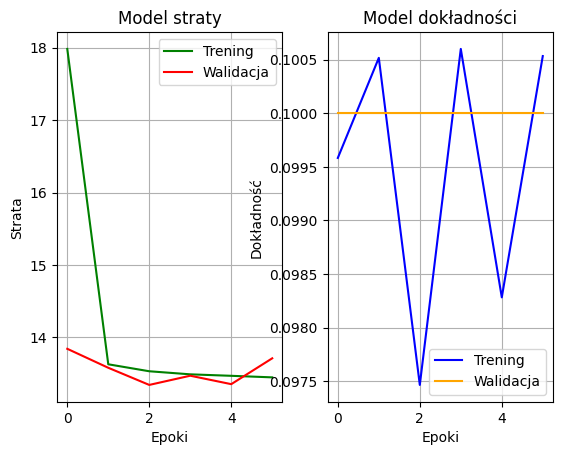

In [63]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
from tensorflow.keras.regularizers import l1

# Przygotowanie danych
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Konwersja i normalizacja danych
x_train = x_train.reshape((-1, 28, 28, 1)) / 255.0
x_test = x_test.reshape((-1, 28, 28, 1)) / 255.0

# Hiperparametry
num_classes = 10 # Number of classes
num_features = 784 # Number of input features (28*28)
num_layers=3
learning_rate = 0.01
training_steps = 3000
batch_size = 128
activation_hidden='relu'
activation_exit='softmax'
dropout_rate = 0.2
l1_reg=0.01

# Definiowanie funkcji tworzącej model z regularyzacją L1
def create_model(learning_rate=0.01, num_layers=2, activation_hidden='relu', activation_exit='softmax', dropout_rate=0.5, l1_reg=0.01):
    model = Sequential()
    model.add(Input(shape=(28, 28, 1)))
    model.add(Flatten())
    for _ in range(num_layers):
        model.add(Dense(512, activation=activation_hidden, kernel_regularizer=l1(l1_reg)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(256, activation=activation_exit))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=["accuracy"])
    return model

# Tworzenie modelu z przykładowymi hiperparametrami regularyzacji
model = create_model(learning_rate=learning_rate, num_layers=num_layers, activation_hidden=activation_hidden, activation_exit=activation_exit, dropout_rate=dropout_rate, l1_reg=l1_reg)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Trenowanie modelu
history = model.fit(
    x_train, y_train,
    epochs=training_steps // (len(x_train) // batch_size),
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=2,
    callbacks=[early_stopping]
)

# Ocena modelu
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nDokładnośc testowa:', test_acc)


# Wykresy
print("Historia straty i dokładności:")
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='g')
plt.plot(history.history['val_loss'], label='Validation Loss', color='r')
plt.title("Model straty")
plt.xlabel("Epoki")
plt.ylabel("Strata")
plt.legend(["Trening", "Walidacja"], loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['val_accuracy'], color='orange')
plt.title("Model dokładności")
plt.xlabel("Epoki")
plt.ylabel("Dokładność")
plt.legend(["Trening", "Walidacja"], loc='lower right')
plt.grid(True)

plt.show()

### Wersja 12
Dodanie regularyzacji L2.<br>

Epoch 1/6
469/469 - 8s - 17ms/step - accuracy: 0.6635 - loss: 1.8163 - val_accuracy: 0.7431 - val_loss: 1.0223
Epoch 2/6
469/469 - 7s - 14ms/step - accuracy: 0.6919 - loss: 1.1718 - val_accuracy: 0.7275 - val_loss: 1.0421
Epoch 3/6
469/469 - 6s - 14ms/step - accuracy: 0.6827 - loss: 1.1698 - val_accuracy: 0.7063 - val_loss: 1.1320
Epoch 4/6
469/469 - 7s - 15ms/step - accuracy: 0.6676 - loss: 1.1984 - val_accuracy: 0.7426 - val_loss: 0.9794
Epoch 5/6
469/469 - 7s - 15ms/step - accuracy: 0.6377 - loss: 1.2063 - val_accuracy: 0.6993 - val_loss: 1.0093
Epoch 6/6
469/469 - 7s - 15ms/step - accuracy: 0.6338 - loss: 1.1797 - val_accuracy: 0.6943 - val_loss: 0.9885
313/313 - 1s - 3ms/step - accuracy: 0.6943 - loss: 0.9885

Dokładnośc testowa: 0.6942999958992004
Historia straty i dokładności:


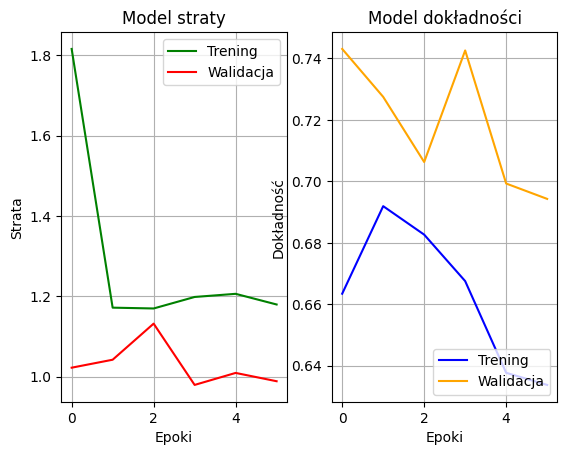

In [64]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
from tensorflow.keras.regularizers import l2

# Przygotowanie danych
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Konwersja i normalizacja danych
x_train = x_train.reshape((-1, 28, 28, 1)) / 255.0
x_test = x_test.reshape((-1, 28, 28, 1)) / 255.0

# Hiperparametry
num_classes = 10 # Number of classes
num_features = 784 # Number of input features (28*28)
num_layers=3
learning_rate = 0.01
training_steps = 3000
batch_size = 128
activation_hidden='relu'
activation_exit='softmax'
dropout_rate = 0.2
l2_reg=0.01

# Definiowanie funkcji tworzącej model z regularyzacją L1
def create_model(learning_rate=0.01, num_layers=2, activation_hidden='relu', activation_exit='softmax', dropout_rate=0.5, l2_reg=0.01):
    model = Sequential()
    model.add(Input(shape=(28, 28, 1)))
    model.add(Flatten())
    for _ in range(num_layers):
        model.add(Dense(512, activation=activation_hidden, kernel_regularizer=l2(l2_reg)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(256, activation=activation_exit))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=["accuracy"])
    return model

# Tworzenie modelu z przykładowymi hiperparametrami regularyzacji
model = create_model(learning_rate=learning_rate, num_layers=num_layers, activation_hidden=activation_hidden, activation_exit=activation_exit, dropout_rate=dropout_rate, l2_reg=l2_reg)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Trenowanie modelu
history = model.fit(
    x_train, y_train,
    epochs=training_steps // (len(x_train) // batch_size),
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=2,
    callbacks=[early_stopping]
)

# Ocena modelu
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nDokładnośc testowa:', test_acc)


# Wykresy
print("Historia straty i dokładności:")
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='g')
plt.plot(history.history['val_loss'], label='Validation Loss', color='r')
plt.title("Model straty")
plt.xlabel("Epoki")
plt.ylabel("Strata")
plt.legend(["Trening", "Walidacja"], loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['val_accuracy'], color='orange')
plt.title("Model dokładności")
plt.xlabel("Epoki")
plt.ylabel("Dokładność")
plt.legend(["Trening", "Walidacja"], loc='lower right')
plt.grid(True)

plt.show()

# Wersja 13
Modyfikacja liczby neuronów.

Epoch 1/6
469/469 - 13s - 28ms/step - accuracy: 0.7309 - loss: 0.9277 - val_accuracy: 0.8067 - val_loss: 0.5543
Epoch 2/6
469/469 - 12s - 27ms/step - accuracy: 0.7888 - loss: 0.6011 - val_accuracy: 0.8180 - val_loss: 0.5261
Epoch 3/6
469/469 - 13s - 28ms/step - accuracy: 0.7975 - loss: 0.5925 - val_accuracy: 0.8216 - val_loss: 0.4952
Epoch 4/6
469/469 - 13s - 28ms/step - accuracy: 0.8005 - loss: 0.5941 - val_accuracy: 0.8218 - val_loss: 0.5263
Epoch 5/6
469/469 - 13s - 28ms/step - accuracy: 0.8010 - loss: 0.5889 - val_accuracy: 0.8288 - val_loss: 0.5073
Epoch 6/6
469/469 - 13s - 27ms/step - accuracy: 0.8037 - loss: 0.5900 - val_accuracy: 0.8321 - val_loss: 0.5686
313/313 - 1s - 4ms/step - accuracy: 0.8321 - loss: 0.5686

Dokładnośc testowa: 0.832099974155426
Historia straty i dokładności:


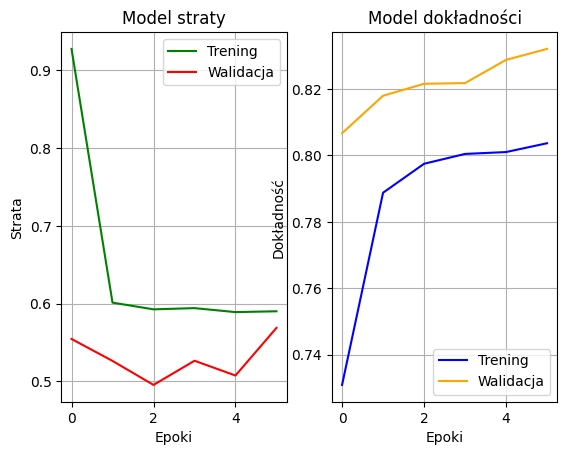

In [65]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input

# Przygotowanie danych
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Konwersja i normalizacja danych
x_train = x_train.reshape((-1, 28, 28, 1)) / 255.0
x_test = x_test.reshape((-1, 28, 28, 1)) / 255.0

# Hiperparametry
num_classes = 10 # Number of classes
num_features = 784 # Number of input features (28*28)
num_layers=3
learning_rate = 0.01
training_steps = 3000
batch_size = 128
activation_hidden='relu'
activation_exit='softmax'
dropout_rate = 0.2

def create_model(learning_rate=0.01, num_layers=2, activation_hidden='relu', activation_exit='softmax', dropout_rate=0.5):
    model = Sequential()
    model.add(Input(shape=(28, 28, 1)))
    model.add(Flatten())
    for _ in range(num_layers):
        model.add(Dense(1024, activation=activation_hidden))
        model.add(Dropout(dropout_rate))
    model.add(Dense(256, activation=activation_exit))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=["accuracy"])
    return model

# Tworzenie modelu z przykładowymi hiperparametrami regularyzacji
model = create_model(learning_rate=learning_rate, num_layers=num_layers, activation_hidden=activation_hidden, activation_exit=activation_exit, dropout_rate=dropout_rate)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Trenowanie modelu
history = model.fit(
    x_train, y_train,
    epochs=training_steps // (len(x_train) // batch_size),
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=2,
    callbacks=[early_stopping]
)

# Ocena modelu
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nDokładnośc testowa:', test_acc)


# Wykresy
print("Historia straty i dokładności:")
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='g')
plt.plot(history.history['val_loss'], label='Validation Loss', color='r')
plt.title("Model straty")
plt.xlabel("Epoki")
plt.ylabel("Strata")
plt.legend(["Trening", "Walidacja"], loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['val_accuracy'], color='orange')
plt.title("Model dokładności")
plt.xlabel("Epoki")
plt.ylabel("Dokładność")
plt.legend(["Trening", "Walidacja"], loc='lower right')
plt.grid(True)

plt.show()

# Wersja 14
Zmiana liczby neuronów między warstwami.<br>
Zmiana liczby epok.

Epoch 1/5
469/469 - 4s - 9ms/step - accuracy: 0.7282 - loss: 0.7754 - val_accuracy: 0.8075 - val_loss: 0.5741
Epoch 2/5
469/469 - 4s - 8ms/step - accuracy: 0.7778 - loss: 0.6347 - val_accuracy: 0.8172 - val_loss: 0.5237
Epoch 3/5
469/469 - 4s - 9ms/step - accuracy: 0.7901 - loss: 0.6106 - val_accuracy: 0.8124 - val_loss: 0.5460
Epoch 4/5
469/469 - 4s - 9ms/step - accuracy: 0.7869 - loss: 0.6135 - val_accuracy: 0.8125 - val_loss: 0.5328
Epoch 5/5
469/469 - 4s - 9ms/step - accuracy: 0.7701 - loss: 0.6772 - val_accuracy: 0.8008 - val_loss: 0.5549
313/313 - 1s - 2ms/step - accuracy: 0.8008 - loss: 0.5549

Dokładnośc testowa: 0.8008000254631042
Historia straty i dokładności:


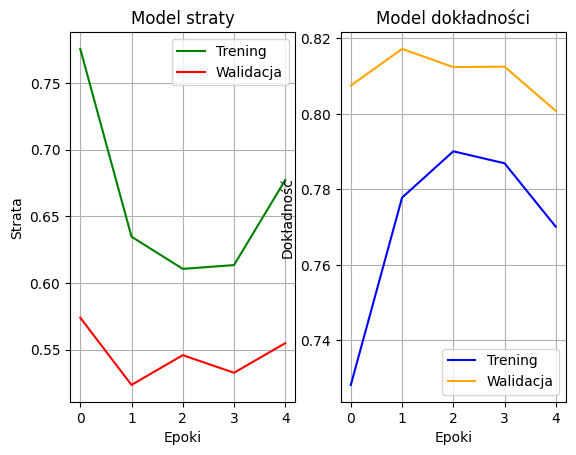

In [66]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input

# Przygotowanie danych
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Konwersja i normalizacja danych
x_train = x_train.reshape((-1, 28, 28, 1)) / 255.0
x_test = x_test.reshape((-1, 28, 28, 1)) / 255.0

# Hiperparametry
num_classes = 10 # Number of classes
num_features = 784 # Number of input features (28*28)
num_layers=4
epochs = 5
learning_rate = 0.01
batch_size = 128
activation_hidden='relu'
activation_exit='softmax'
dropout_rate = 0.2

def create_model(learning_rate=0.01, num_layers=2, activation_hidden='relu', activation_exit='softmax', dropout_rate=0.5):
    model = Sequential()
    model.add(Input(shape=(28, 28, 1)))
    model.add(Flatten())
    for _ in range(num_layers):
        model.add(Dense(256, activation=activation_hidden))
        model.add(Dropout(dropout_rate))
    model.add(Dense(512, activation=activation_exit))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=["accuracy"])
    return model

# Tworzenie modelu z przykładowymi hiperparametrami regularyzacji
model = create_model(learning_rate=learning_rate, num_layers=num_layers, activation_hidden=activation_hidden, activation_exit=activation_exit, dropout_rate=dropout_rate)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Trenowanie modelu
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=2,
    callbacks=[early_stopping]
)

# Ocena modelu
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nDokładnośc testowa:', test_acc)


# Wykresy
print("Historia straty i dokładności:")
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='g')
plt.plot(history.history['val_loss'], label='Validation Loss', color='r')
plt.title("Model straty")
plt.xlabel("Epoki")
plt.ylabel("Strata")
plt.legend(["Trening", "Walidacja"], loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['val_accuracy'], color='orange')
plt.title("Model dokładności")
plt.xlabel("Epoki")
plt.ylabel("Dokładność")
plt.legend(["Trening", "Walidacja"], loc='lower right')
plt.grid(True)

plt.show()

# Wersja 15
Zmiana funkcji aktywacji

Epoch 1/5
469/469 - 4s - 9ms/step - accuracy: 0.3932 - loss: 1.4021 - val_accuracy: 0.6365 - val_loss: 0.8619
Epoch 2/5
469/469 - 3s - 7ms/step - accuracy: 0.7177 - loss: 0.7329 - val_accuracy: 0.7701 - val_loss: 0.5935
Epoch 3/5
469/469 - 3s - 7ms/step - accuracy: 0.7798 - loss: 0.5983 - val_accuracy: 0.7835 - val_loss: 0.5618
Epoch 4/5
469/469 - 3s - 7ms/step - accuracy: 0.8045 - loss: 0.5393 - val_accuracy: 0.8174 - val_loss: 0.5028
Epoch 5/5
469/469 - 4s - 9ms/step - accuracy: 0.8202 - loss: 0.5085 - val_accuracy: 0.8378 - val_loss: 0.4578
313/313 - 0s - 1ms/step - accuracy: 0.8378 - loss: 0.4578

Dokładnośc testowa: 0.8378000259399414
Historia straty i dokładności:


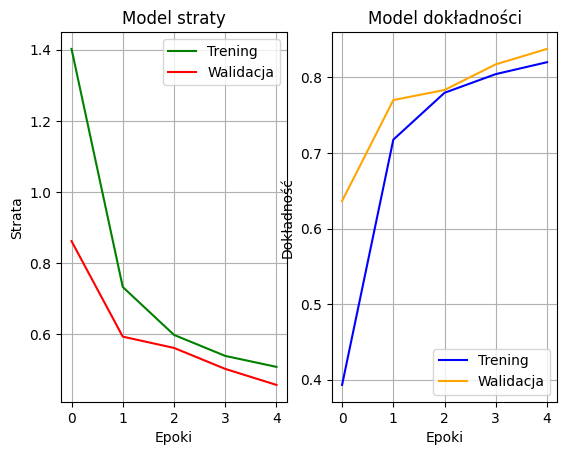

In [67]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input

# Przygotowanie danych
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Konwersja i normalizacja danych
x_train = x_train.reshape((-1, 28, 28, 1)) / 255.0
x_test = x_test.reshape((-1, 28, 28, 1)) / 255.0

# Hiperparametry
num_classes = 10 # Number of classes
num_features = 784 # Number of input features (28*28)
num_layers=4
epochs = 5
learning_rate = 0.01
batch_size = 128
activation_hidden='sigmoid'
activation_exit='softmax'
dropout_rate = 0.2

def create_model(learning_rate=0.01, num_layers=2, activation_hidden='relu', activation_exit='softmax', dropout_rate=0.5):
    model = Sequential()
    model.add(Input(shape=(28, 28, 1)))
    model.add(Flatten())
    for _ in range(num_layers):
        model.add(Dense(256, activation=activation_hidden))
        model.add(Dropout(dropout_rate))
    model.add(Dense(512, activation=activation_exit))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=["accuracy"])
    return model

# Tworzenie modelu z przykładowymi hiperparametrami regularyzacji
model = create_model(learning_rate=learning_rate, num_layers=num_layers, activation_hidden=activation_hidden, activation_exit=activation_exit, dropout_rate=dropout_rate)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Trenowanie modelu
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=2,
    callbacks=[early_stopping]
)

# Ocena modelu
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nDokładnośc testowa:', test_acc)


# Wykresy
print("Historia straty i dokładności:")
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='g')
plt.plot(history.history['val_loss'], label='Validation Loss', color='r')
plt.title("Model straty")
plt.xlabel("Epoki")
plt.ylabel("Strata")
plt.legend(["Trening", "Walidacja"], loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['val_accuracy'], color='orange')
plt.title("Model dokładności")
plt.xlabel("Epoki")
plt.ylabel("Dokładność")
plt.legend(["Trening", "Walidacja"], loc='lower right')
plt.grid(True)

plt.show()

# Wersja 16
Zmiana rozmiaru paczki.

Epoch 1/5
235/235 - 4s - 16ms/step - accuracy: 0.3030 - loss: 1.6037 - val_accuracy: 0.4803 - val_loss: 1.0770
Epoch 2/5
235/235 - 3s - 11ms/step - accuracy: 0.6285 - loss: 0.8766 - val_accuracy: 0.7201 - val_loss: 0.6507
Epoch 3/5
235/235 - 3s - 12ms/step - accuracy: 0.7765 - loss: 0.6079 - val_accuracy: 0.8127 - val_loss: 0.5227
Epoch 4/5
235/235 - 3s - 13ms/step - accuracy: 0.8136 - loss: 0.5253 - val_accuracy: 0.8361 - val_loss: 0.4660
Epoch 5/5
235/235 - 3s - 15ms/step - accuracy: 0.8335 - loss: 0.4811 - val_accuracy: 0.8394 - val_loss: 0.4576
313/313 - 0s - 2ms/step - accuracy: 0.8394 - loss: 0.4576

Dokładnośc testowa: 0.8393999934196472
Historia straty i dokładności:


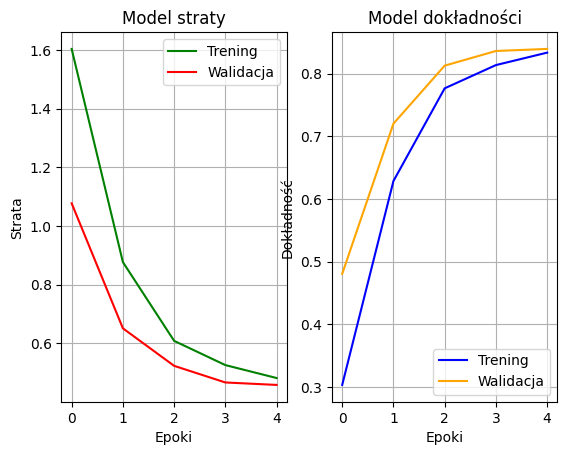

In [68]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input

# Przygotowanie danych
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Konwersja i normalizacja danych
x_train = x_train.reshape((-1, 28, 28, 1)) / 255.0
x_test = x_test.reshape((-1, 28, 28, 1)) / 255.0

# Hiperparametry
num_classes = 10 # Number of classes
num_features = 784 # Number of input features (28*28)
num_layers=4
epochs = 5
learning_rate = 0.01
batch_size = 256
activation_hidden='sigmoid'
activation_exit='softmax'
dropout_rate = 0.2

def create_model(learning_rate=0.01, num_layers=2, activation_hidden='relu', activation_exit='softmax', dropout_rate=0.5):
    model = Sequential()
    model.add(Input(shape=(28, 28, 1)))
    model.add(Flatten())
    for _ in range(num_layers):
        model.add(Dense(256, activation=activation_hidden))
        model.add(Dropout(dropout_rate))
    model.add(Dense(512, activation=activation_exit))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=["accuracy"])
    return model

# Tworzenie modelu z przykładowymi hiperparametrami regularyzacji
model = create_model(learning_rate=learning_rate, num_layers=num_layers, activation_hidden=activation_hidden, activation_exit=activation_exit, dropout_rate=dropout_rate)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Trenowanie modelu
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=2,
    callbacks=[early_stopping]
)

# Ocena modelu
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nDokładnośc testowa:', test_acc)


# Wykresy
print("Historia straty i dokładności:")
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='g')
plt.plot(history.history['val_loss'], label='Validation Loss', color='r')
plt.title("Model straty")
plt.xlabel("Epoki")
plt.ylabel("Strata")
plt.legend(["Trening", "Walidacja"], loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['val_accuracy'], color='orange')
plt.title("Model dokładności")
plt.xlabel("Epoki")
plt.ylabel("Dokładność")
plt.legend(["Trening", "Walidacja"], loc='lower right')
plt.grid(True)

plt.show()

# Wersja 17
Zmiana liczby epok.
Dodanie regularyzacji L2.

Epoch 1/3
235/235 - 3s - 12ms/step - accuracy: 0.4390 - loss: 1.9021 - val_accuracy: 0.4087 - val_loss: 1.8488
Epoch 2/3
235/235 - 2s - 10ms/step - accuracy: 0.5199 - loss: 1.5590 - val_accuracy: 0.5954 - val_loss: 1.4053
Epoch 3/3
235/235 - 2s - 10ms/step - accuracy: 0.5391 - loss: 1.5053 - val_accuracy: 0.4897 - val_loss: 1.6411
313/313 - 0s - 1ms/step - accuracy: 0.4897 - loss: 1.6411

Dokładnośc testowa: 0.48969998955726624
Historia straty i dokładności:


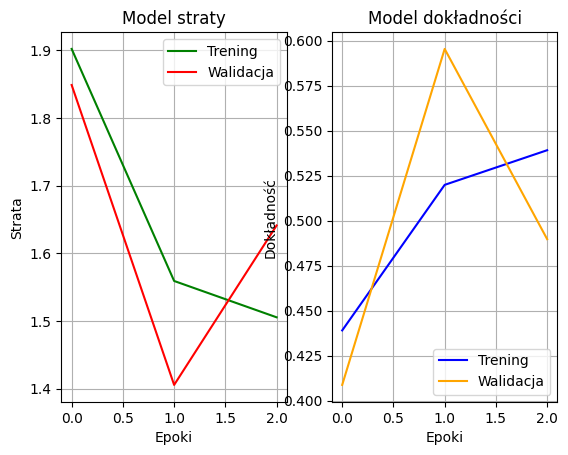

In [61]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
from tensorflow.keras.regularizers import l2

# Przygotowanie danych
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Konwersja i normalizacja danych
x_train = x_train.reshape((-1, 28, 28, 1)) / 255.0
x_test = x_test.reshape((-1, 28, 28, 1)) / 255.0

# Hiperparametry
num_classes = 10 # Number of classes
num_features = 784 # Number of input features (28*28)
num_layers=2
epochs = 3
learning_rate = 0.01
batch_size = 256
activation_hidden='sigmoid'
activation_exit='softmax'
dropout_rate = 0.2
l2_reg=0.01

def create_model(learning_rate=0.01, num_layers=2, activation_hidden='relu', activation_exit='softmax', dropout_rate=0.5, l2_reg=0.01):
    model = Sequential()
    model.add(Input(shape=(28, 28, 1)))
    model.add(Flatten())
    for _ in range(num_layers):
        model.add(Dense(256, activation=activation_hidden, kernel_regularizer=l2(l2_reg)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(512, activation=activation_exit))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=["accuracy"])
    return model

# Tworzenie modelu z przykładowymi hiperparametrami regularyzacji
model = create_model(learning_rate=learning_rate, num_layers=num_layers, activation_hidden=activation_hidden, activation_exit=activation_exit, dropout_rate=dropout_rate, l2_reg=l2_reg)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Trenowanie modelu
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=2,
    callbacks=[early_stopping]
)

# Ocena modelu
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nDokładnośc testowa:', test_acc)


# Wykresy
print("Historia straty i dokładności:")
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='g')
plt.plot(history.history['val_loss'], label='Validation Loss', color='r')
plt.title("Model straty")
plt.xlabel("Epoki")
plt.ylabel("Strata")
plt.legend(["Trening", "Walidacja"], loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['val_accuracy'], color='orange')
plt.title("Model dokładności")
plt.xlabel("Epoki")
plt.ylabel("Dokładność")
plt.legend(["Trening", "Walidacja"], loc='lower right')
plt.grid(True)

plt.show()

# Wersja 18
Zwiększenie dropout_rate

Epoch 1/5
235/235 - 3s - 13ms/step - accuracy: 0.5829 - loss: 1.0509 - val_accuracy: 0.7690 - val_loss: 0.6240
Epoch 2/5
235/235 - 2s - 10ms/step - accuracy: 0.7945 - loss: 0.5661 - val_accuracy: 0.8284 - val_loss: 0.4808
Epoch 3/5
235/235 - 2s - 10ms/step - accuracy: 0.8296 - loss: 0.4799 - val_accuracy: 0.8444 - val_loss: 0.4323
Epoch 4/5
235/235 - 3s - 11ms/step - accuracy: 0.8419 - loss: 0.4450 - val_accuracy: 0.8479 - val_loss: 0.4179
Epoch 5/5
235/235 - 3s - 11ms/step - accuracy: 0.8500 - loss: 0.4189 - val_accuracy: 0.8558 - val_loss: 0.3936
313/313 - 0s - 1ms/step - accuracy: 0.8558 - loss: 0.3936

Dokładnośc testowa: 0.8557999730110168
Historia straty i dokładności:


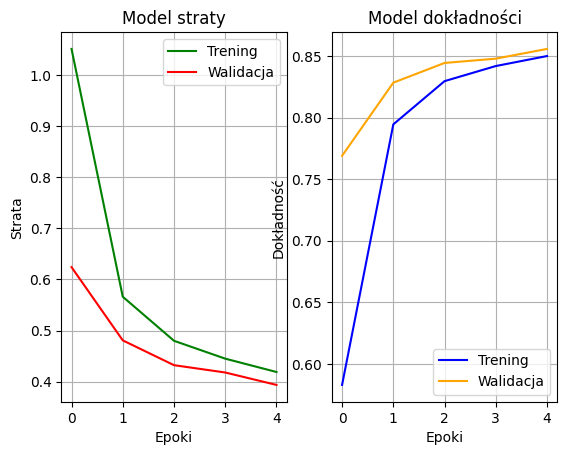

In [69]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input

# Przygotowanie danych
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Konwersja i normalizacja danych
x_train = x_train.reshape((-1, 28, 28, 1)) / 255.0
x_test = x_test.reshape((-1, 28, 28, 1)) / 255.0

# Hiperparametry
num_classes = 10 # Number of classes
num_features = 784 # Number of input features (28*28)
num_layers=4
epochs = 5
learning_rate = 0.01
batch_size = 256
activation_hidden='sigmoid'
activation_exit='softmax'
dropout_rate = 0.3

def create_model(learning_rate=0.01, num_layers=2, activation_hidden='relu', activation_exit='softmax', dropout_rate=0.5):
    model = Sequential()
    model.add(Input(shape=(28, 28, 1)))
    model.add(Flatten())
    for _ in range(num_layers-1):
        model.add(Dense(256, activation=activation_hidden))
        model.add(Dropout(dropout_rate))
    model.add(Dense(512, activation=activation_exit))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=["accuracy"])
    return model

# Tworzenie modelu z przykładowymi hiperparametrami regularyzacji
model = create_model(learning_rate=learning_rate, num_layers=num_layers, activation_hidden=activation_hidden, activation_exit=activation_exit, dropout_rate=dropout_rate)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Trenowanie modelu
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=2,
    callbacks=[early_stopping]
)

# Ocena modelu
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nDokładnośc testowa:', test_acc)


# Wykresy
print("Historia straty i dokładności:")
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='g')
plt.plot(history.history['val_loss'], label='Validation Loss', color='r')
plt.title("Model straty")
plt.xlabel("Epoki")
plt.ylabel("Strata")
plt.legend(["Trening", "Walidacja"], loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['val_accuracy'], color='orange')
plt.title("Model dokładności")
plt.xlabel("Epoki")
plt.ylabel("Dokładność")
plt.legend(["Trening", "Walidacja"], loc='lower right')
plt.grid(True)

plt.show()

# Wersja 19
Zmniejszenie learning_rate

Epoch 1/5
235/235 - 3s - 14ms/step - accuracy: 0.3690 - loss: 1.6965 - val_accuracy: 0.7021 - val_loss: 0.8014
Epoch 2/5
235/235 - 2s - 10ms/step - accuracy: 0.7599 - loss: 0.6467 - val_accuracy: 0.8038 - val_loss: 0.5199
Epoch 3/5
235/235 - 2s - 10ms/step - accuracy: 0.8213 - loss: 0.5046 - val_accuracy: 0.8360 - val_loss: 0.4628
Epoch 4/5
235/235 - 2s - 10ms/step - accuracy: 0.8373 - loss: 0.4578 - val_accuracy: 0.8358 - val_loss: 0.4446
Epoch 5/5
235/235 - 2s - 10ms/step - accuracy: 0.8479 - loss: 0.4290 - val_accuracy: 0.8528 - val_loss: 0.4186
313/313 - 0s - 1ms/step - accuracy: 0.8528 - loss: 0.4186

Dokładnośc testowa: 0.8528000116348267
Historia straty i dokładności:


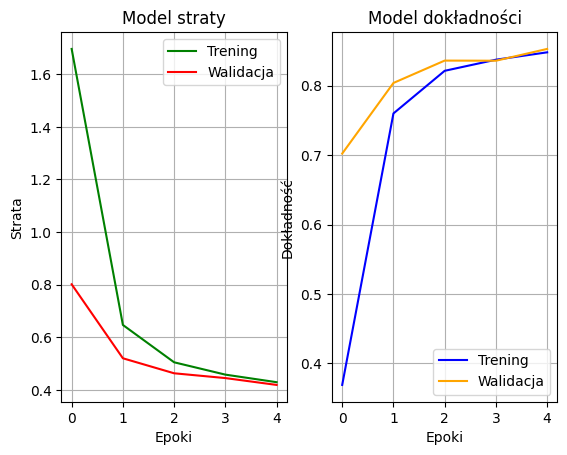

In [70]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input

# Przygotowanie danych
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Konwersja i normalizacja danych
x_train = x_train.reshape((-1, 28, 28, 1)) / 255.0
x_test = x_test.reshape((-1, 28, 28, 1)) / 255.0

# Hiperparametry
num_classes = 10 # Number of classes
num_features = 784 # Number of input features (28*28)
num_layers=4
epochs = 5
learning_rate = 0.001
batch_size = 256
activation_hidden='sigmoid'
activation_exit='softmax'
dropout_rate = 0.3

def create_model(learning_rate=0.01, num_layers=2, activation_hidden='relu', activation_exit='softmax', dropout_rate=0.5):
    model = Sequential()
    model.add(Input(shape=(28, 28, 1)))
    model.add(Flatten())
    for _ in range(num_layers-1):
        model.add(Dense(256, activation=activation_hidden))
        model.add(Dropout(dropout_rate))
    model.add(Dense(512, activation=activation_exit))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=["accuracy"])
    return model

# Tworzenie modelu z przykładowymi hiperparametrami regularyzacji
model = create_model(learning_rate=learning_rate, num_layers=num_layers, activation_hidden=activation_hidden, activation_exit=activation_exit, dropout_rate=dropout_rate)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Trenowanie modelu
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=2,
    callbacks=[early_stopping]
)

# Ocena modelu
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nDokładnośc testowa:', test_acc)


# Wykresy
print("Historia straty i dokładności:")
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='g')
plt.plot(history.history['val_loss'], label='Validation Loss', color='r')
plt.title("Model straty")
plt.xlabel("Epoki")
plt.ylabel("Strata")
plt.legend(["Trening", "Walidacja"], loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['val_accuracy'], color='orange')
plt.title("Model dokładności")
plt.xlabel("Epoki")
plt.ylabel("Dokładność")
plt.legend(["Trening", "Walidacja"], loc='lower right')
plt.grid(True)

plt.show()

# Wersja 20
Znaczne zwiększenie liczby epok.

Epoch 1/40
235/235 - 3s - 14ms/step - accuracy: 0.3904 - loss: 1.6840 - val_accuracy: 0.7123 - val_loss: 0.7619
Epoch 2/40
235/235 - 3s - 11ms/step - accuracy: 0.7576 - loss: 0.6419 - val_accuracy: 0.8042 - val_loss: 0.5312
Epoch 3/40
235/235 - 3s - 11ms/step - accuracy: 0.8197 - loss: 0.5118 - val_accuracy: 0.8352 - val_loss: 0.4633
Epoch 4/40
235/235 - 2s - 10ms/step - accuracy: 0.8374 - loss: 0.4592 - val_accuracy: 0.8443 - val_loss: 0.4339
Epoch 5/40
235/235 - 2s - 10ms/step - accuracy: 0.8476 - loss: 0.4301 - val_accuracy: 0.8496 - val_loss: 0.4168
Epoch 6/40
235/235 - 3s - 15ms/step - accuracy: 0.8547 - loss: 0.4068 - val_accuracy: 0.8566 - val_loss: 0.4009
Epoch 7/40
235/235 - 5s - 21ms/step - accuracy: 0.8603 - loss: 0.3929 - val_accuracy: 0.8603 - val_loss: 0.3902
Epoch 8/40
235/235 - 5s - 23ms/step - accuracy: 0.8646 - loss: 0.3775 - val_accuracy: 0.8633 - val_loss: 0.3803
Epoch 9/40
235/235 - 3s - 12ms/step - accuracy: 0.8674 - loss: 0.3692 - val_accuracy: 0.8653 - val_loss:

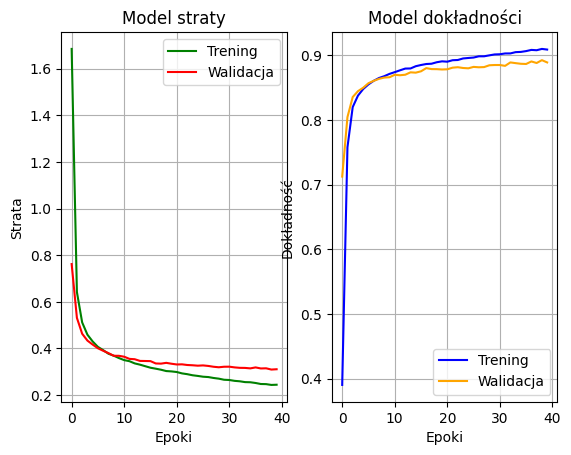

In [72]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input

# Przygotowanie danych
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Konwersja i normalizacja danych
x_train = x_train.reshape((-1, 28, 28, 1)) / 255.0
x_test = x_test.reshape((-1, 28, 28, 1)) / 255.0

# Hiperparametry
num_classes = 10 # Number of classes
num_features = 784 # Number of input features (28*28)
num_layers=4
epochs = 40
learning_rate = 0.001
batch_size = 256
activation_hidden='sigmoid'
activation_exit='softmax'
dropout_rate = 0.3

def create_model(learning_rate=0.01, num_layers=2, activation_hidden='relu', activation_exit='softmax', dropout_rate=0.5):
    model = Sequential()
    model.add(Input(shape=(28, 28, 1)))
    model.add(Flatten())
    for _ in range(num_layers-1):
        model.add(Dense(256, activation=activation_hidden))
        model.add(Dropout(dropout_rate))
    model.add(Dense(512, activation=activation_exit))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=["accuracy"])
    return model

# Tworzenie modelu z przykładowymi hiperparametrami regularyzacji
model = create_model(learning_rate=learning_rate, num_layers=num_layers, activation_hidden=activation_hidden, activation_exit=activation_exit, dropout_rate=dropout_rate)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Trenowanie modelu
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=2,
    callbacks=[early_stopping]
)

# Ocena modelu
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nDokładnośc testowa:', test_acc)


# Wykresy
print("Historia straty i dokładności:")
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='g')
plt.plot(history.history['val_loss'], label='Validation Loss', color='r')
plt.title("Model straty")
plt.xlabel("Epoki")
plt.ylabel("Strata")
plt.legend(["Trening", "Walidacja"], loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['val_accuracy'], color='orange')
plt.title("Model dokładności")
plt.xlabel("Epoki")
plt.ylabel("Dokładność")
plt.legend(["Trening", "Walidacja"], loc='lower right')
plt.grid(True)

plt.show()